**Author**: Tuan Le   
**Mail**: <tuanle@hotmail.de>  
**Script**: `LinearRegression.ipynb`  

### Method 1: (stable) normal equations: ###
When we have the (multiple) linear model and assuming $\mathbf{\theta}$ already includes the bias term, hence dim($\theta$) = p+1, we obtain following model: $$ (I):\mathbf{y} = \mathbf{X}\mathbf{\theta}$$  
It turns out that with some linear algebra minimizing the L2 (sum of squares error) objective function:  
$$ (II):L(\mathbf{\theta}) = \frac{1}{2}(\mathbf{y} - \mathbf{X}\mathbf{\theta})'(\mathbf{y} - \mathbf{X}\mathbf{\theta})$$

We obtain [derivation](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression):    
$$(III): \mathbf{\theta} = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y} $$  
as solver of the loss function. It is recommendable instead of directly inverting the inner product $(\mathbf{X}'\mathbf{X})$ (note this involves 2 computations, first the inner product and second the inversion of the inner product) to use **QR-Decomposition** due to numerical stability:
[stable Least Squares](http://genomicsclass.github.io/book/pages/qr_and_regression.html).

### Method 2 (stochastic) gradient descent: ###
Assuming we have to linear model in equation $(I)$, (stochastic) gradient descent tries to adjust the weights $\mathbf{\theta}$ in the next iteration/epoch, such that the loss **decreases**. For a detailed explanation have a look at following [link](https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3).  
The update rule is as follows:  
$$ (IV): \mathbf{\theta} \leftarrow \mathbf{\theta} - \alpha * \nabla_{\mathbf{\theta}} L(\mathbf{\theta}) $$
where the gradient is taken with respect to the weights vector $\mathbf{\theta}$.
After computing the gradient it turns out that the gradient is equal to:  

$$\nabla_{\mathbf{\theta}} L(\mathbf{\theta}) = -\mathbf{X}'\mathbf{y} + \mathbf{X}'\mathbf{X}\mathbf{\theta}$$  
$$\nabla_{\mathbf{\theta}} L(\mathbf{\theta}) = -\mathbf{X}'[\mathbf{y} - \mathbf{X}\mathbf{\theta}]$$  
$$\nabla_{\mathbf{\theta}} L(\mathbf{\theta}) = -\mathbf{X}'[\mathbf{y} - \hat{\mathbf{y}}]$$  
and hence the gradient update as follows:
$$\mathbf{\theta} \leftarrow \mathbf{\theta} - \alpha * ( -\mathbf{X}'[\mathbf{y} - \mathbf{X}\mathbf{\theta}] )$$
$$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha * \mathbf{X}'[\mathbf{y} - \mathbf{X}\mathbf{\theta}]$$
$$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha * \mathbf{X}'[\mathbf{y} - \hat{\mathbf{y}}]$$  

  
in order to have stable gradient updates take the average gradient. (Note as long as the update rule is **proportional** to the original gradient, it is all fine. Hence we have:
$$\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha * \frac{1}{n} \mathbf{X}'[\mathbf{y} - \hat{\mathbf{y}}]$$  

### Implementation of `MyLinearRegression` object: ###

In [1]:
import numpy as np
from numpy.linalg import inv, qr
from numpy import transpose 
import matplotlib.pyplot as plt

In [2]:
class MyLinearRegression():
    
    ### Constructor ###
    def __init__(self, X, y):
        '''
        Init method for LinearRegression Object. 
        
        Parameters:
        X: Numpy Feature matrix (without intercept)
        y: target vector
        
        Returns:
        LinearRegression object with saved data
        '''
        self.X = X
        self.n = X.shape[0]
        self.p = X.shape[1] + 1
        self.y = y.reshape((self.n, 1))
        
    ### Methods ###
    
    def empirical_risk(self, X, y, w):
        '''
        Computes L2 empirical risk
        
        Paramaters
        ----------
        X : Feature matrix
        y : target vector
        w : weight vector
        
        Returns
        -------
        Empirical Risk from the dataset
        '''
        
        residuals = np.square(y - np.matmul(X, w))
        empirical_risk = 0.5*np.sum(residuals)
        
        return empirical_risk
    
    def l2_deriv(self, y, y_hat, X):
        '''
        Computes the derivative of the L2 loss wrt. the weights
        
        Paramaters
        ----------
        y : true target vector
        y_hat : predicted target vector
        X : Feature matrix
        
        Returns
        -------
        (averaged) derivative of loss wrt. to weights
        '''
        a = y - y_hat
        grad = -1*np.matmul(X.T, a)
        avg_grad = 1/self.n * grad
        return avg_grad
        
        
    def predict(self, X):
        '''
        Computes the the prediction
        
        Paramaters
        ----------
        X : Feature matrix
        
        Returns
        -------
        (averaged) derivative of loss wrt. to weights
        '''
        y_hat = np.matmul(X, self.w)
        y_hat = y_hat.reshape((len(y_hat), 1))
        
        return y_hat


    def train(self, max_iter, optim = "GD", mini_batch_size = None, lr = 0.01):
        '''
        Computes the derivative of the L2 loss wrt. the weights
        
        Paramaters
        ----------
        max_iter : Maximal number of iterations (for weight update)
        optim : Optimization method. Either Gradient Descent 'GD' or Stochastic Gradient Descent 'SGD' 
        mini_batch_size : size of mini batch for stochastic gradient descent
        lr : learning rate for weight update
        
        Returns
        -------
        None
        '''
        ## Concatenate intercept into feature matrix
        self.X = np.column_stack((np.ones(shape=(self.n,1)), self.X))
        ## Init random weights
        self.w = np.random.normal(size=self.p)
        self.w = self.w.reshape((self.p, 1))
        ## Init loss history
        self.loss_history = np.zeros(max_iter)
        ## Train the LinearRegression Model with Method 2
        for i in range(max_iter):
            y_hat = self.predict(X=self.X)
            self.loss_history[i] = self.empirical_risk(X=self.X, y=self.y, w=self.w)
            if i % 10 == 0 or i == max_iter:
                print("Empirical risk in iteration:" + str(i) + ": " + str(self.loss_history[i]))
            if optim == "GD":
                idx = np.arange(self.n)
            elif optim == "SGD":
                if mini_batch_size == None:
                    mini_batch_size = int(np.ceil(self.n/4))
                idx = np.random.choice(a=np.arange(self.n), size=mini_batch_size, replace=True)
            grad = self.l2_deriv(y=self.y[idx], y_hat=y_hat[idx], X=self.X[idx,:])
            self.w = self.w - lr*grad
        
        ## Method 1
        ## unstable
        self.w_unstable = inv(self.X.T.dot(self.X))
        self.w_unstable = self.w_unstable.dot(self.X.T)
        self.w_unstable = self.w_unstable.dot(self.y)
        
        ##stable with QR-decomposition
        self.Q, self.R = qr(self.X)
        self.w_stable = inv(self.R).dot(self.Q.T).dot(self.y)
        
    
    def plot_history(self):
        loss_history = np.array(self.loss_history).reshape(len(self.loss_history),1)
        plt.plot(range(len(loss_history)),loss_history)
        plt.show()
        

In [3]:
### Testing simple linear regression: ###
X = np.random.uniform(low=-5, high=5, size=(200,1))
weights = np.array([2])
intercept = 3
y = np.matmul(X, weights) + intercept + np.random.normal(size=200)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80)

C:\Users\GIWRU\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
print(X_train.shape)
print(y_train.shape)

(160, 1)
(160,)


In [6]:
print(X_test.shape)
print(y_test.shape)

(40, 1)
(40,)


In [7]:
my_lr = MyLinearRegression(X=X_train, y=y_train)
my_lr.train(max_iter=500, lr=0.01, optim = "GD")

Empirical risk in iteration:0: 5717.063743164057
Empirical risk in iteration:10: 1258.7159092561697
Empirical risk in iteration:20: 484.7776355382956
Empirical risk in iteration:30: 320.45994319188526
Empirical risk in iteration:40: 262.5352282440187
Empirical risk in iteration:50: 227.63514258150957
Empirical risk in iteration:60: 201.1256378566664
Empirical risk in iteration:70: 179.77525696241855
Empirical risk in iteration:80: 162.36663435047723
Empirical risk in iteration:90: 148.13668499667773
Empirical risk in iteration:100: 136.49922354903072
Empirical risk in iteration:110: 126.98099222480064
Empirical risk in iteration:120: 119.19591627485264
Empirical risk in iteration:130: 112.82838381490195
Empirical risk in iteration:140: 107.6202777111392
Empirical risk in iteration:150: 103.36048420058694
Empirical risk in iteration:160: 99.87633065994589
Empirical risk in iteration:170: 97.02658549257727
Empirical risk in iteration:180: 94.69573312503812
Empirical risk in iteration:190

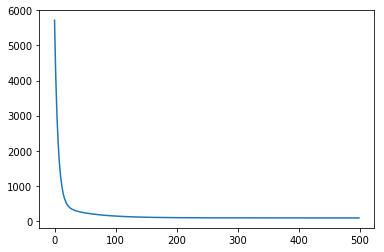

In [8]:
my_lr.plot_history()

In [9]:
print(my_lr.w)

[[2.93951097]
 [2.02854632]]


In [10]:
print(my_lr.w_stable)

[[2.95402477]
 [2.02858529]]


In [11]:
print(my_lr.w_unstable)

[[2.95402477]
 [2.02858529]]


### Check results from sklearn module: ###

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lm = LinearRegression()
model = lm.fit(X_train,y_train)

In [14]:
print(model.intercept_)
print(model.coef_)

2.9540247714568117
[2.02858529]


In [15]:
import matplotlib.pyplot as plt
X_test = np.column_stack((np.ones(shape=(len(X_test),1)), X_test))
y_test_pred = my_lr.predict(X=X_test)

### Plot output on test data: ###

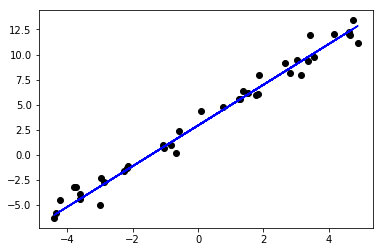

In [16]:
plt.scatter(X_test[:,1], y_test,  color='black')
plt.plot(X_test[:,1], y_test_pred, color='blue')
plt.show()

### Test Multiple Linear Regression ###

In [17]:
### Testing multiple linear regression without train/test validation: ###
X = np.random.uniform(low=-5, high=5, size=(200,3))
weights = np.array([2, 5, -3])
intercept = -2
y = np.matmul(X, weights) + intercept + np.random.normal(size=200)

In [18]:
my_lr = MyLinearRegression(X=X, y=y)
my_lr.train(max_iter=500, lr=0.01, optim = "GD")

Empirical risk in iteration:0: 44969.754039084495
Empirical risk in iteration:10: 8039.719848559215
Empirical risk in iteration:20: 1714.3887692501708
Empirical risk in iteration:30: 570.885885926708
Empirical risk in iteration:40: 332.7519198302421
Empirical risk in iteration:50: 261.85361709030866
Empirical risk in iteration:60: 226.48401632601897
Empirical risk in iteration:70: 201.78905784650897
Empirical risk in iteration:80: 182.39584408979547
Empirical risk in iteration:90: 166.6840920977199
Empirical risk in iteration:100: 153.85661353714158
Empirical risk in iteration:110: 143.36409502583615
Empirical risk in iteration:120: 134.7774715178456
Empirical risk in iteration:130: 127.74971894404369
Empirical risk in iteration:140: 121.99765697897911
Empirical risk in iteration:150: 117.28968366524524
Empirical risk in iteration:160: 113.43627303489738
Empirical risk in iteration:170: 110.28230844421027
Empirical risk in iteration:180: 107.70083065080485
Empirical risk in iteration:1

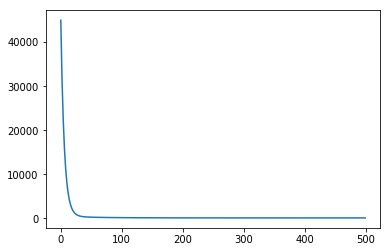

In [19]:
my_lr.plot_history()

In [20]:
print(my_lr.w)
print(my_lr.w_stable)
print(my_lr.w_unstable)

[[-2.01515566]
 [ 2.02482528]
 [ 4.99213104]
 [-2.98388492]]
[[-2.02901736]
 [ 2.02463468]
 [ 4.9921677 ]
 [-2.98414321]]
[[-2.02901736]
 [ 2.02463468]
 [ 4.9921677 ]
 [-2.98414321]]


In [21]:
lm = LinearRegression(fit_intercept=True)
model = lm.fit(X,y)

In [22]:
print(model.intercept_)
print(model.coef_)

-2.029017355535923
[ 2.02463468  4.9921677  -2.98414321]


### Try out stochastig gradient descent ###

In [23]:
my_lr = MyLinearRegression(X=X, y=y)
my_lr.train(max_iter=1500, lr=0.01, optim = "SGD")

Empirical risk in iteration:0: 46128.387959653955
Empirical risk in iteration:10: 29371.365093562486
Empirical risk in iteration:20: 18862.271783643522
Empirical risk in iteration:30: 12625.420780061559
Empirical risk in iteration:40: 8369.813405565295
Empirical risk in iteration:50: 5441.503916517128
Empirical risk in iteration:60: 3665.614933136123
Empirical risk in iteration:70: 2407.608780794655
Empirical risk in iteration:80: 1641.795856518486
Empirical risk in iteration:90: 1142.779046315195
Empirical risk in iteration:100: 827.2576774176664
Empirical risk in iteration:110: 615.1897795295438
Empirical risk in iteration:120: 473.206480546161
Empirical risk in iteration:130: 378.9194362527507
Empirical risk in iteration:140: 317.00025423000045
Empirical risk in iteration:150: 274.2005067607334
Empirical risk in iteration:160: 245.49898962588486
Empirical risk in iteration:170: 221.97812096442556
Empirical risk in iteration:180: 207.25351907782266
Empirical risk in iteration:190: 19

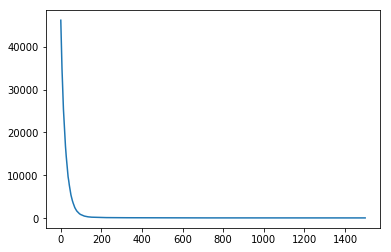

In [24]:
my_lr.plot_history()

In [25]:
### END ###